In [84]:
import pandas as pd 
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from matplotlib import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [64]:
# Read all  parquet files in the folder and store them in a dataframe
df = pd.concat([pd.read_parquet(f) for f in glob.glob(r'C:\git\JADS\group repos\DCIA-GROUP-9\Data\*.parquet')], ignore_index = True)
df['date_code'] = pd.to_datetime(df['date_code'], format='%Y%m%d', errors='coerce')
df.sort_values(by=['date_code'],inplace=True)
df_without4 = df[df['period_code'] != 4]
df.reset_index(drop=True, inplace=True)
df_without4.reset_index(drop=True, inplace=True)

Check if all stores are available in all perids to avoid unwanted effects

In [65]:
# Filter the DataFrame for the first three periods
period1_stores = df[df['period_code'] == 1]['store_code'].unique()
period2_stores = df[df['period_code'] == 2]['store_code'].unique()
period3_stores = df[df['period_code'] == 3]['store_code'].unique()
period4_stores = df[df['period_code'] == 4]['store_code'].unique()

# Check whether the store codes in period 1 are the same as those in period 2
print(set(period1_stores) == set(period2_stores))
print(set(period1_stores) == set(period3_stores))
print(set(period1_stores) == set(period4_stores))

# Check whether the store codes in period 2 are the same as those in period 3
print(set(period2_stores) == set(period3_stores))
print(set(period2_stores) == set(period4_stores))

# Check whether the store codes in period 3 are the same as those in period 4
print(set(period3_stores) == set(period4_stores))

True
True
True
True
True
True


In [66]:
# Reset index ans sorn  values
df.reset_index(drop=True, inplace=True)
df.sort_values(by=['date_code'],inplace=True)

Check if any of the stores were closed for a longer period of time

In [67]:
# Find the longest period of consecutive non-visits
stores_period4 = df[df['period_code'] == 4].groupby('store_code')
for code, store_group in stores_period4:
    # Get date of the first visit
    latest_visit = store_group.iloc[0]['date_code']
    duration = 0

    # Go thrpugh all the rows in the group
    for index, row in store_group.iterrows():
        new_duration = row['date_code'] - latest_visit
        new_duration  = int(new_duration.days)
        if new_duration > duration:
            duration = new_duration
        latest_visit = row['date_code']

    print(f"Store {code}: Longest period of non-visits = {duration}")


Store 201: Longest period of non-visits = 1
Store 202: Longest period of non-visits = 1
Store 209: Longest period of non-visits = 1
Store 210: Longest period of non-visits = 1
Store 212: Longest period of non-visits = 1
Store 213: Longest period of non-visits = 1
Store 215: Longest period of non-visits = 1
Store 216: Longest period of non-visits = 1
Store 217: Longest period of non-visits = 1
Store 220: Longest period of non-visits = 1
Store 221: Longest period of non-visits = 1
Store 222: Longest period of non-visits = 1
Store 223: Longest period of non-visits = 1
Store 224: Longest period of non-visits = 1
Store 225: Longest period of non-visits = 1
Store 226: Longest period of non-visits = 1
Store 228: Longest period of non-visits = 1
Store 229: Longest period of non-visits = 1
Store 230: Longest period of non-visits = 1
Store 232: Longest period of non-visits = 1
Store 234: Longest period of non-visits = 1
Store 235: Longest period of non-visits = 1
Store 236: Longest period of non

Preprocessing...

In [68]:
# Create a new DataFrame with the necessary columns
new_df = df[['date_code', 'period_code', 'customer_code', 'revenue_after_discount_incl_vat']]

# Aggregate the data by date and period
new_df = new_df.groupby(['date_code', 'period_code']).agg({'customer_code': 'count', 'revenue_after_discount_incl_vat': 'sum'})

# Rename the aggregated columns
new_df = new_df.rename(columns={'customer_code': 'num_customers', 'revenue_after_discount_incl_vat': 'total_revenue'})

# Create a new DataFrame with the necessary columns
week_df = df[['date_code', 'period_code']]

# Get the start date for each period
start_dates = week_df.groupby('period_code').agg({'date_code': 'min'})

# Create a dictionary mapping period codes to start dates
start_date_dict = start_dates.to_dict()['date_code']

# Define a function to calculate the week number for a given date and period
def get_week(date, period):
    start_date = start_date_dict[period]
    days_since_start = (date - start_date).days
    week = (days_since_start // 7) + 1
    return week

# Define a function to calculate the day number for a given date and period
def get_day(date, period):
    start_date = start_date_dict[period]
    days_since_start = (date - start_date).days
    return days_since_start

# Apply the get_week function to each row in the DataFrame
week_df['week'] = week_df.apply(lambda x: get_week(x['date_code'], x['period_code']), axis=1)

# Apply the get_day function to each row in the DataFrame
week_df['day'] = week_df.apply(lambda x: get_day(x['date_code'], x['period_code']), axis=1)

# Merge the week column back into the new_df DataFrame
new_df = pd.merge(new_df, week_df[['date_code', 'period_code', 'week', 'day']], on=['date_code', 'period_code'])

# Reset the index to create separate columns for date and period
new_df = new_df.reset_index()

new_df['treatment'] = ((new_df['period_code'] == 3) | (new_df['period_code'] == 4)).astype(int)

# Create a binary indicator column for the post-treatment period
new_df['post'] = ((new_df['period_code'] == 2) | (new_df['period_code'] == 4)).astype(int)

# Create an interaction term between treatment and post
new_df['treatment_post'] = new_df['treatment'] * new_df['post']

# Create an interaction term between week and post
new_df['week_post'] = new_df['post'] * new_df['week']
new_df['week_post_treatment'] = new_df['post'] * new_df['week'] * new_df['treatment']

# Create a variable indicating wheather the day is a weekend or not based on date_code
new_df['weekend'] = new_df['date_code'].dt.dayofweek // 5

# Create an interaction term between weekend and post
new_df['weekend_post'] = new_df['post'] * new_df['weekend']

# Create an interaction term between weekend and treatment
new_df['weekend_treatment'] = new_df['treatment'] * new_df['weekend']

# Create an interaction term between weekend and treatment_post
new_df['weekend_treatment_post'] = new_df['treatment_post'] * new_df['weekend']

# Create a column indicating if it is friday or not
new_df['friday'] = (new_df['date_code'].dt.dayofweek == 4).astype(int)

# Create an interaction term between friday and post treatment
new_df['friday_treatment_post'] = new_df['treatment_post'] * new_df['friday']
# Drop index
new_df = new_df.drop(columns=['index'])
new_df


,date_code,period_code,num_customers,total_revenue,week,day,treatment,post,treatment_post,week_post,week_post_treatment,weekend,weekend_post,weekend_treatment,weekend_treatment_post,friday,friday_treatment_post
0,2020-06-29,1,5863,13593107.92,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2020-06-29,1,5863,13593107.92,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2020-06-29,1,5863,13593107.92,1,0,0,0,0,0,0,0,0,0,0,0,0
3,2020-06-29,1,5863,13593107.92,1,0,0,0,0,0,0,0,0,0,0,0,0
4,2020-06-29,1,5863,13593107.92,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252962,2022-04-03,4,4505,13924454.33,20,139,1,1,1,20,20,1,1,1,1,0,0
3252963,2022-04-03,4,4505,13924454.33,20,139,1,1,1,20,20,1,1,1,1,0,0
3252964,2022-04-03,4,4505,13924454.33,20,139,1,1,1,20,20,1,1,1,1,0,0
3252965,2022-04-03,4,4505,13924454.33,20,139,1,1,1,20,20,1,1,1,1,0,0


Difference in differences for total revenue and number of customers per day

In [69]:
# Fit a linear regression model with the interaction term and other covariates for number of customers
X = new_df[['post', 'treatment','treatment_post', 'week_post_treatment', 'weekend', 'weekend_treatment_post','friday','friday_treatment_post']]
X = sm.add_constant(X)
y = new_df['num_customers']
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          num_customers   R-squared:                       0.411
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                 2.833e+05
Date:                Fri, 09 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:57:02   Log-Likelihood:            -2.4952e+07
No. Observations:             3252967   AIC:                         4.990e+07
Df Residuals:                 3252958   BIC:                         4.990e+07
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   6106

In [70]:
# Fit a linear regression model with the interaction term and other covariates for total reveue
y = new_df['total_revenue'] 
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                 1.015e+05
Date:                Fri, 09 Jun 2023   Prob (F-statistic):               0.00
Time:                        22:57:05   Log-Likelihood:            -5.4667e+07
No. Observations:             3252967   AIC:                         1.093e+08
Df Residuals:                 3252958   BIC:                         1.093e+08
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.38

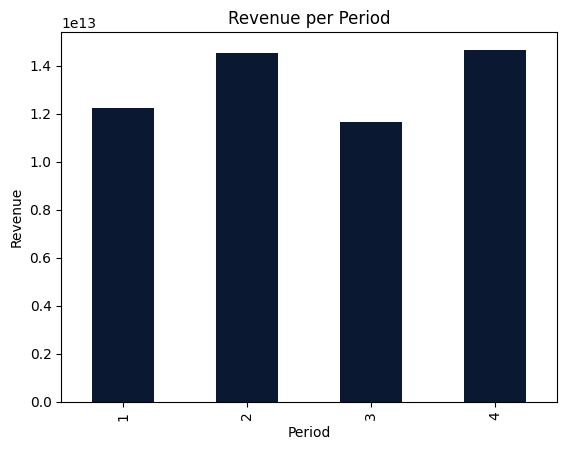

In [71]:
# Visualzie revenue per period to check the result consistancy 
new_df.groupby('period_code')['total_revenue'].sum().plot(kind='bar', color='#0a1931')
plt.xlabel('Period')
plt.ylabel('Revenue')
plt.title('Revenue per Period')
plt.show()


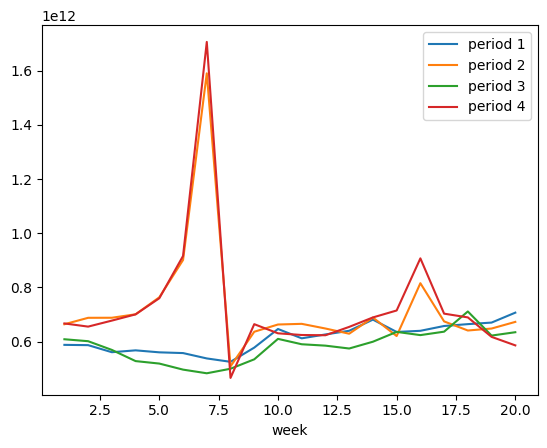

In [72]:
# Compare total revenue per week per period
# Plot total revenu per day in a line chart
new_df[new_df['period_code']==1].groupby(['week'])['total_revenue'].sum().plot(kind='line')
new_df[new_df['period_code']==2].groupby(['week'])['total_revenue'].sum().plot(kind='line')
new_df[new_df['period_code']==3].groupby(['week'])['total_revenue'].sum().plot(kind='line')
new_df[new_df['period_code']==4].groupby(['week'])['total_revenue'].sum().plot(kind='line')
plt.legend(['period 1', 'period 2', 'period 3', 'period 4'])


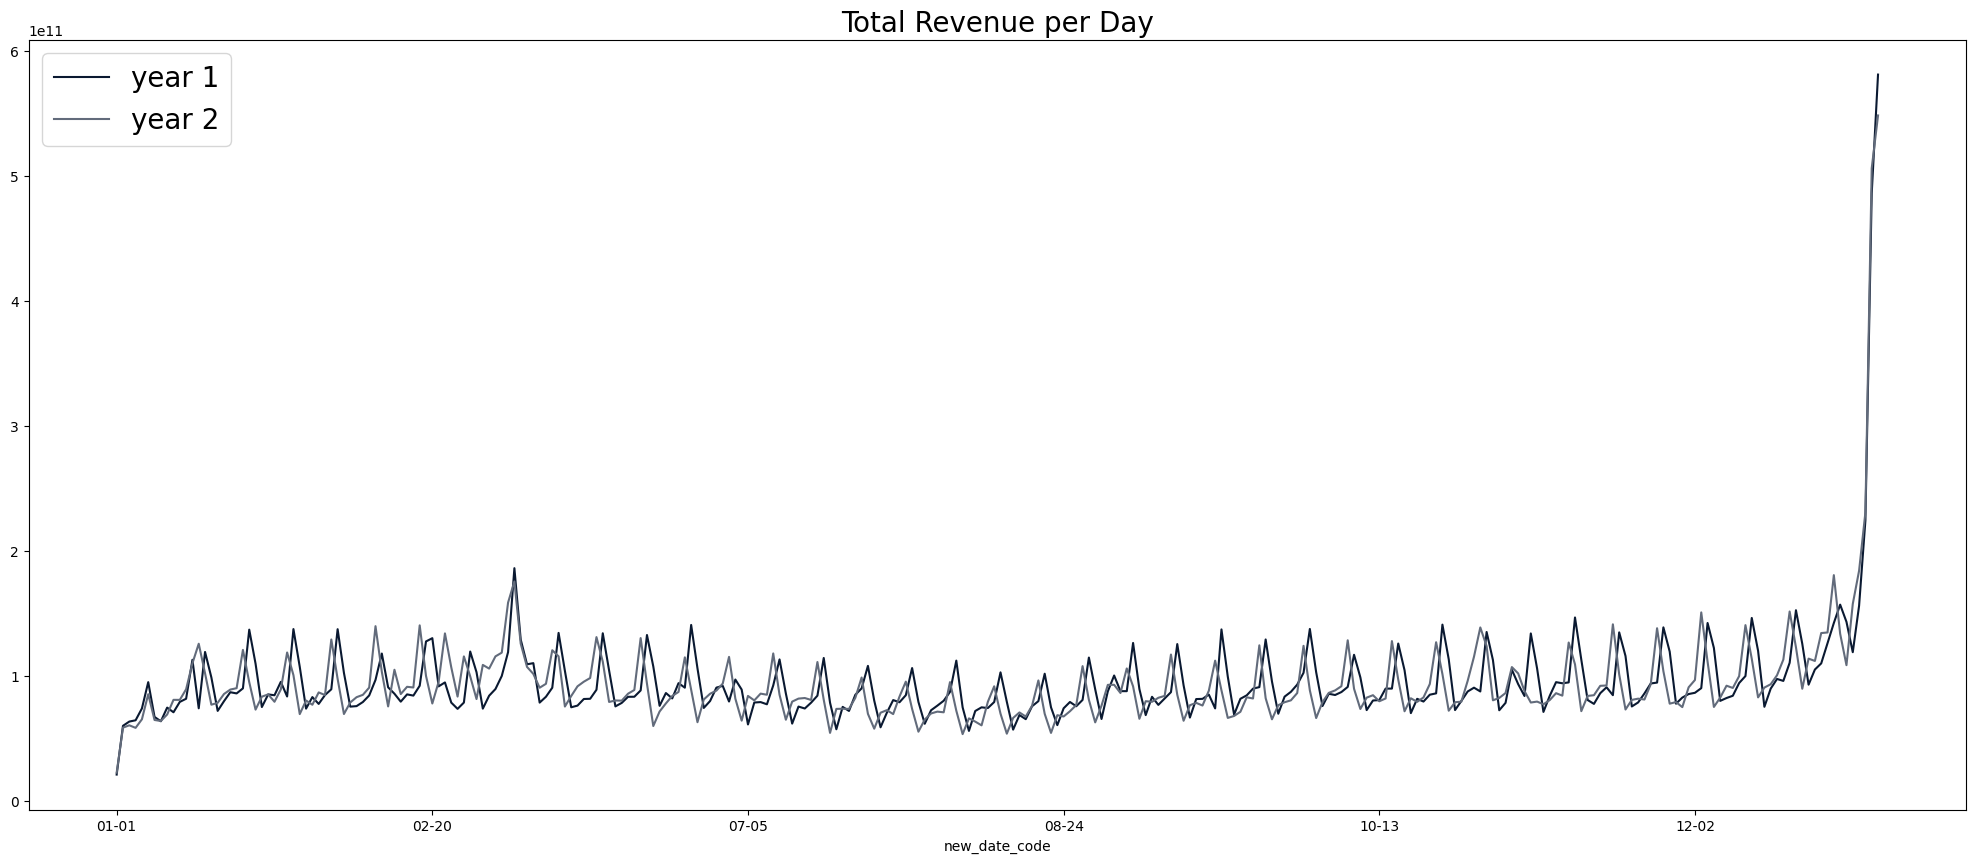

In [73]:
# Make new_date_code not include year
new_df['new_date_code'] = new_df['date_code'].dt.strftime('%m-%d')
# See the general data trend for revenue per day
new_df[new_df['period_code'].isin([1,2])].groupby(['new_date_code'])['total_revenue'].sum().plot(kind='line', figsize=(25,10),color='#0a1931')
new_df[new_df['period_code'].isin([3,4])].groupby(['new_date_code'])['total_revenue'].sum().plot(kind='line',color='#626b7b')

plt.title('Total Revenue per Day', fontsize=20)
plt.legend(['year 1', 'year 2'], prop={'size': 20})

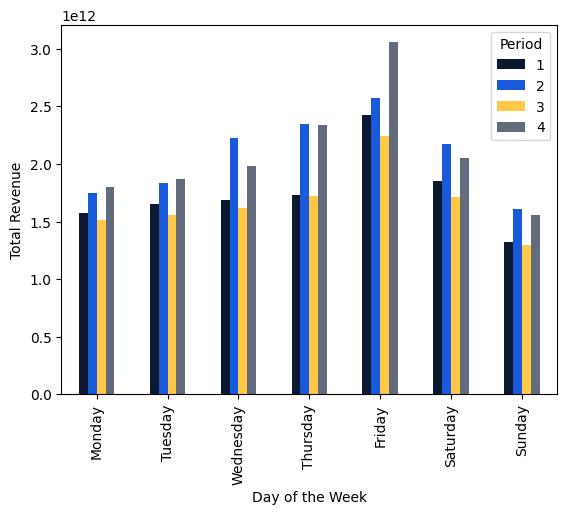

In [74]:
# Total revenue per day per period
# Make a column in new_df that indicates the day of the week
new_df['day_of_week'] = new_df['date_code'].dt.dayofweek

# Transform the day of the week column to string names of the days
new_df['day_of_week'] = new_df['day_of_week'].replace([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
new_df['day_of_week'] = pd.Categorical(new_df['day_of_week'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Bar chart of total revenue per day of the week per period, with color specified by period
new_df.groupby(['period_code', 'day_of_week'])['total_revenue'].sum().unstack(0).plot.bar(color=['#0a1931', '#185adb', '#ffc947', '#626b7b'])

plt.xlabel("Day of the Week")
plt.ylabel("Total Revenue")
plt.legend(title="Period", bbox_to_anchor=(1, 1))

plt.show()


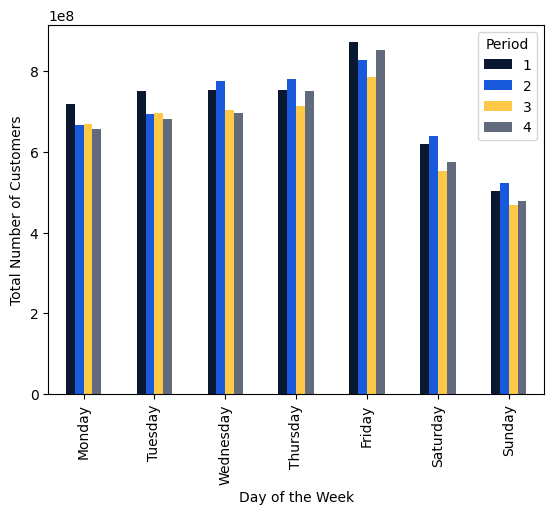

In [75]:
# Total number of customers per day per period
new_df.groupby(['period_code', 'day_of_week'])['num_customers'].sum().unstack(0).plot.bar(color=['#0a1931', '#185adb', '#ffc947', '#626b7b'])

plt.xlabel("Day of the Week")
plt.ylabel("Total Number of Customers")
plt.legend(title="Period", bbox_to_anchor=(1, 1))

plt.show()

Difference in differences for revenue and number of visits per customer

Preprocessing...

In [76]:
df_period_1_3 = df[df['period_code'] != 4].reset_index()

df_period_4 = df[df['period_code'] == 4].reset_index()

df_period_1_3['visits'] = df_period_1_3.groupby('customer_code')['customer_code'].transform('count') # Number of visits per customer
avg_visits = df_period_1_3['visits'].mean() # Average amount of visits
df_period_1_3['Visits_score'] = df_period_1_3['visits'] / avg_visits # Amount of visits of customer compared to average 
df_period_1_3['norm_visits_score'] = (df_period_1_3['Visits_score'] - df_period_1_3['Visits_score'].mean()) / df_period_1_3['Visits_score'].std() # Normalized


df_period_1_3['total_money_spent'] = df_period_1_3.groupby('customer_code')['revenue_after_discount_incl_vat'].transform('sum') # Total money spent by customer
avg_money_spent = df_period_1_3['revenue_after_discount_incl_vat'].mean() * avg_visits # Average money spent (average spent per visit * average store visits)
df_period_1_3['total_money_spent_score'] = df_period_1_3['total_money_spent'] / avg_money_spent
df_period_1_3['norm_total_money_spent_score'] = (df_period_1_3['total_money_spent_score'] - df_period_1_3['total_money_spent_score'].mean()) / df_period_1_3['total_money_spent_score'].std()

# Group by customer_code and calculate the standard deviation of revenue_after_discount_incl_vat for each customer_code
df_period_1_3['purchase_fluc'] = df_period_1_3.groupby('customer_code')['revenue_after_discount_incl_vat'].transform('std') # Total fluctuation of money spent per visit
avg_purchase_fluc = df_period_1_3['purchase_fluc'].mean(skipna=True) # Average fluctuation
df_period_1_3['norm_purchase_fluc'] = ((df_period_1_3['purchase_fluc'] - df_period_1_3['purchase_fluc'].mean(skipna=True)) / df_period_1_3['purchase_fluc'].std(skipna=True)) *-1
df_period_1_3['norm_purchase_fluc'] = df_period_1_3['norm_purchase_fluc'].fillna(0)
# A low/negative value here means that the fluctuation rate is low, which indicates that a customer is loyal
# Solution -> Mirror the values by value *-1
df_period_1_3['loyalty_score_1_3'] = (0.33 * df_period_1_3['norm_visits_score']) + (0.33 * df_period_1_3['norm_total_money_spent_score']) + (0.33* df_period_1_3['norm_purchase_fluc'])

df_period_4['visits'] = df_period_4.groupby('customer_code')['customer_code'].transform('count') # Number of visits per customer
avg_visits = df_period_4['visits'].mean() # Average amount of visits
df_period_4['Visits_score'] = df_period_4['visits'] / avg_visits # Amount of visits of customer compared to average 
df_period_4['norm_visits_score'] = (df_period_4['Visits_score'] - df_period_4['Visits_score'].mean()) / df_period_4['Visits_score'].std() # Normalized


df_period_4['total_money_spent'] = df_period_4.groupby('customer_code')['revenue_after_discount_incl_vat'].transform('sum') # Total money spent by customer
avg_money_spent = df_period_4['revenue_after_discount_incl_vat'].mean() * avg_visits # Average money spent (average spent per visit * average store visits)
df_period_4['total_money_spent_score'] = df_period_4['total_money_spent'] / avg_money_spent
df_period_4['norm_total_money_spent_score'] = (df_period_4['total_money_spent_score'] - df_period_4['total_money_spent_score'].mean()) / df_period_4['total_money_spent_score'].std()

# Group by customer_code and calculate the standard deviation of revenue_after_discount_incl_vat for each customer_code
df_period_4['purchase_fluc'] = df_period_4.groupby('customer_code')['revenue_after_discount_incl_vat'].transform('std') # Total fluctuation of money spent per visit
avg_purchase_fluc = df_period_4['purchase_fluc'].mean(skipna=True) # Average fluctuation
df_period_4['norm_purchase_fluc'] = ((df_period_4['purchase_fluc'] - df_period_4['purchase_fluc'].mean(skipna=True)) / df_period_4['purchase_fluc'].std(skipna=True)) *-1
df_period_4['norm_purchase_fluc'] = df_period_4['norm_purchase_fluc'].fillna(0)
# A low/negative value here means that the fluctuation rate is low, which indicates that a customer is loyal
# Solution -> Mirror the values by value *-1
df_period_4['loyalty_score_4'] = (0.33 * df_period_4['norm_visits_score']) + (0.33 * df_period_4['norm_total_money_spent_score']) + (0.33* df_period_4['norm_purchase_fluc'])
df_period_1_3.drop_duplicates(subset=['customer_code'], inplace=True)
min_value_1_3 = df_period_1_3['loyalty_score_1_3'].quantile(0.25)
max_value_1_3 = df_period_1_3['loyalty_score_1_3'].quantile(0.75)
step_1_3 = (abs(min_value_1_3) + abs(max_value_1_3)) / 5


df_period_1_3.loc[df_period_1_3["loyalty_score_1_3"] > max_value_1_3, "loyalty_group_1_3"] = 5
df_period_1_3.loc[(df_period_1_3["loyalty_score_1_3"] > (min_value_1_3 + (step_1_3 * 3))) &
                  (df_period_1_3['loyalty_score_1_3'] <= (min_value_1_3 + (step_1_3 * 4))), "loyalty_group_1_3"] = 4
df_period_1_3.loc[(df_period_1_3["loyalty_score_1_3"] > (min_value_1_3 + (step_1_3 * 2))) &
                  (df_period_1_3['loyalty_score_1_3'] <= (min_value_1_3 + (step_1_3 * 3))), "loyalty_group_1_3"] = 3
df_period_1_3.loc[(df_period_1_3["loyalty_score_1_3"] > (min_value_1_3 + step_1_3)) &
                  (df_period_1_3['loyalty_score_1_3'] <= (min_value_1_3 + (step_1_3 * 2))), "loyalty_group_1_3"] = 2
df_period_1_3.loc[df_period_1_3["loyalty_score_1_3"] < min_value_1_3 + step_1_3, "loyalty_group_1_3"] = 1

print("Customers in non-loyal: " + str(len(df_period_1_3[df_period_1_3['loyalty_group_1_3'] == 1])))
print("Customers in not really loyal: " + str(len(df_period_1_3[df_period_1_3['loyalty_group_1_3'] == 2])))
print("Customers in pretty loyal: " + str(len(df_period_1_3[df_period_1_3['loyalty_group_1_3'] == 3])))
print("Customers in loyal: " + str(len(df_period_1_3[df_period_1_3['loyalty_group_1_3'] == 4])))
print("Customers in very loyal: " + str(len(df_period_1_3[df_period_1_3['loyalty_group_1_3'] == 5])))

df_period_1_3 = df_period_1_3[['customer_code', 'loyalty_score_1_3', 'loyalty_group_1_3']]


Customers in non-loyal: 25336
Customers in not really loyal: 7294
Customers in pretty loyal: 3720
Customers in loyal: 2145
Customers in very loyal: 3985


In [85]:
# Aggregate df per customer and per period code
df_per_cust = df.groupby(['customer_code','period_code']).agg({'customer_code':'min','period_code':'min','revenue_after_discount_incl_vat':'sum','quantity_sold':'sum','customer_segment_level_1_code':'count','redeemer_latest_ind':'max'})

# Choose only rows for which the customer_code is in both dataframes df_period_1_3 and df_per_cust
df_per_cust = df_per_cust[df_per_cust['customer_code'].isin(df_period_1_3['customer_code'])]

# Rename the aggregated columns
df_per_cust = df_per_cust.rename(columns={'revenue_after_discount_incl_vat': 'total_revenue', 'quantity_sold':'total_quantity_sold', 'customer_segment_level_1_code':'nr_of_visits'})

df_per_cust['treatment'] = ((df_per_cust['period_code'] == 3) | (df_per_cust['period_code'] == 4)).astype(int)

# Create a binary indicator column for the post-treatment period
df_per_cust['post'] = ((df_per_cust['period_code'] == 2) | (df_per_cust['period_code'] == 4)).astype(int)

# Create an interaction term between treatment and post
df_per_cust['treatment_post'] = df_per_cust['treatment'] * df_per_cust['post']


In [86]:
df_per_cust = df_per_cust.reset_index(drop=True)
df_per_cust = df_per_cust.merge(df_period_1_3, on='customer_code', how='left')
# Rename columns
df_per_cust = df_per_cust.rename(columns={'redeemer_latest_ind':'redeemer', 'loyalty_score_1_3': 'loyalty_score', 'loyalty_group_1_3': 'loyalty_group'})
# Dummyify the loyalty group but keep the original column
df_per_cust['loyalty_group_dummy'] = df_per_cust['loyalty_group']
df_per_cust = pd.get_dummies(df_per_cust, columns=['loyalty_group_dummy'])
df_per_cust = df_per_cust.rename(columns={'loyalty_group_dummy_1.0':'loyalty_group_1', 'loyalty_group_dummy_2.0':'loyalty_group_2', 
                                          'loyalty_group_dummy_3.0':'loyalty_group_3', 'loyalty_group_dummy_4.0':'loyalty_group_4', 
                                          'loyalty_group_dummy_5.0':'loyalty_group_5'})
df_per_cust = df_per_cust.drop(columns=['loyalty_group_3'])
df_per_cust["loyalty_group_1"] = df_per_cust["loyalty_group_1"].astype(float)
df_per_cust["loyalty_group_2"] = df_per_cust["loyalty_group_2"].astype(float)
df_per_cust["loyalty_group_4"] = df_per_cust["loyalty_group_4"].astype(float)
df_per_cust["loyalty_group_5"] = df_per_cust["loyalty_group_5"].astype(float)

# Make an interaction term between redeemer and treatment_post
df_per_cust['redeemer_treatment_post'] = df_per_cust['redeemer'] * df_per_cust['treatment_post']

In [87]:
# Make an interaction term between loyalty group and redeemer_latest_ind
df_per_cust['loyalty_group1_redeemer'] = df_per_cust['loyalty_group_1'] * df_per_cust['redeemer']
df_per_cust['loyalty_group2_redeemer'] = df_per_cust['loyalty_group_2'] * df_per_cust['redeemer']
df_per_cust['loyalty_group4_redeemer'] = df_per_cust['loyalty_group_4'] * df_per_cust['redeemer']
df_per_cust['loyalty_group5_redeemer'] = df_per_cust['loyalty_group_5'] * df_per_cust['redeemer']


# Make an interaction term between loyalty group, redeemer, and treatment_post
df_per_cust['loyalty_group1_redeemer_treatment_post'] = df_per_cust['loyalty_group_1'] * df_per_cust['redeemer'] * df_per_cust['treatment_post']
df_per_cust['loyalty_group2_redeemer_treatment_post'] = df_per_cust['loyalty_group_2'] * df_per_cust['redeemer'] * df_per_cust['treatment_post']
df_per_cust['loyalty_group4_redeemer_treatment_post'] = df_per_cust['loyalty_group_4'] * df_per_cust['redeemer'] * df_per_cust['treatment_post']
df_per_cust['loyalty_group5_redeemer_treatment_post'] = df_per_cust['loyalty_group_5'] * df_per_cust['redeemer'] * df_per_cust['treatment_post']

# Make an interaction between loyalty group and treatment_post
df_per_cust['loyalty_group1_treatment_post'] = df_per_cust['loyalty_group_1'] * df_per_cust['treatment_post']
df_per_cust['loyalty_group2_treatment_post'] = df_per_cust['loyalty_group_2'] * df_per_cust['treatment_post']
df_per_cust['loyalty_group4_treatment_post'] = df_per_cust['loyalty_group_4'] * df_per_cust['treatment_post']
df_per_cust['loyalty_group5_treatment_post'] = df_per_cust['loyalty_group_5'] * df_per_cust['treatment_post']

In [88]:
X = sm.add_constant(df_per_cust[['post', 'treatment', 'treatment_post', 'redeemer',
                                 'loyalty_group_1', 'loyalty_group_2', 'loyalty_group_4', 'loyalty_group_5', 
                                 'loyalty_group1_redeemer_treatment_post', 'loyalty_group2_redeemer_treatment_post', 
                                 'loyalty_group4_redeemer_treatment_post', 'loyalty_group5_redeemer_treatment_post']])


y = df_per_cust['total_revenue']
model = sm.OLS(y, X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          total_revenue   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.382
Method:                 Least Squares   F-statistic:                     8716.
Date:                Fri, 09 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:09:34   Log-Likelihood:            -2.1387e+06
No. Observations:              168968   AIC:                         4.278e+06
Df Residuals:                  168955   BIC:                         4.278e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [89]:
y = df_per_cust['nr_of_visits']
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           nr_of_visits   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                 2.962e+04
Date:                Fri, 09 Jun 2023   Prob (F-statistic):               0.00
Time:                        23:14:42   Log-Likelihood:            -6.7536e+05
No. Observations:              168968   AIC:                         1.351e+06
Df Residuals:                  168955   BIC:                         1.351e+06
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

Mean of residuals: -1.3347613078934584e-13
Median of residuals: -2.0933671242981227
Proportion of positive residuals: 0.4006616637469817


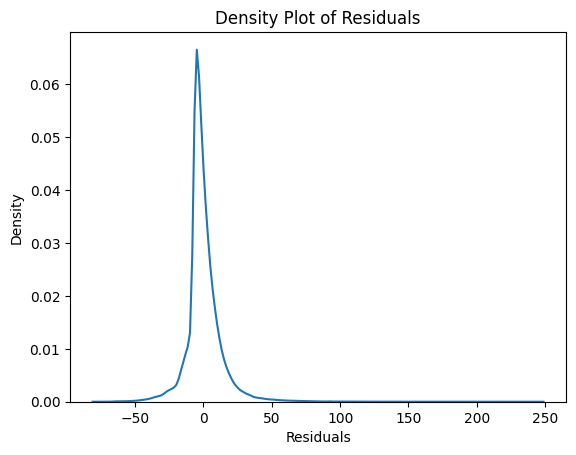

In [90]:
# Get the predicted values from the model
predictions = model.predict(X)

# Calculate the residuals (difference between actual and predicted values)
residuals = y - predictions

# Calculate summary statistics of residuals
residual_mean = residuals.mean()
residual_median = residuals.median()
positive_residual_proportion = (residuals > 0).mean()

print("Mean of residuals:", residual_mean)
print("Median of residuals:", residual_median)
print("Proportion of positive residuals:", positive_residual_proportion)

# Plotting the density plot of residuals
sns.kdeplot(residuals)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Density Plot of Residuals')
plt.show()



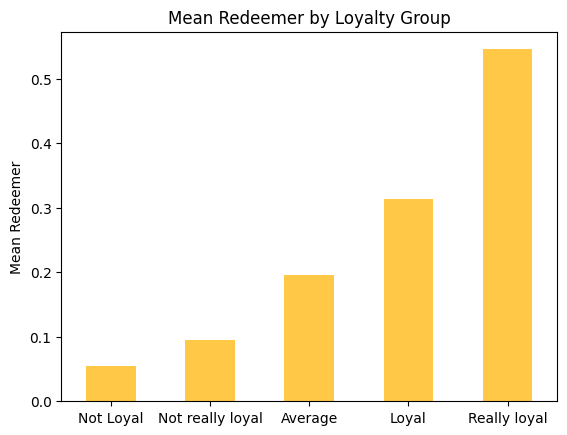

In [91]:
# See how many customers from each loyalty group are redeamers
groups = ['Not Loyal', 'Not really loyal', 'Average', 'Loyal', 'Really loyal']
df_per_cust.groupby('loyalty_group')['redeemer'].mean().plot(kind='bar', color='#ffc947')

plt.xlabel('')
plt.ylabel('Mean Redeemer')
plt.title('Mean Redeemer by Loyalty Group')
plt.xticks(range(len(groups)), groups, rotation='horizontal')
plt.show()


In [92]:
df_period_1_3 = df[df['period_code'] != 4].reset_index()
df_period_4 = df[df['period_code'] == 4].reset_index()

In [93]:
df_period_1_3['visits'] = df_period_1_3.groupby('customer_code')['customer_code'].transform('count') # Number of visits per customer
avg_visits = df_period_1_3['visits'].mean() # Average amount of visits
df_period_1_3['Visits_score'] = df_period_1_3['visits'] / avg_visits # Amount of visits of customer compared to average 
df_period_1_3['norm_visits_score'] = (df_period_1_3['Visits_score'] - df_period_1_3['Visits_score'].mean()) / df_period_1_3['Visits_score'].std() # Normalized


df_period_1_3['total_money_spent'] = df_period_1_3.groupby('customer_code')['revenue_after_discount_incl_vat'].transform('sum') # Total money spent by customer
avg_money_spent = df_period_1_3['revenue_after_discount_incl_vat'].mean() * avg_visits # Average money spent (average spent per visit * average store visits)
df_period_1_3['total_money_spent_score'] = df_period_1_3['total_money_spent'] / avg_money_spent
df_period_1_3['norm_total_money_spent_score'] = (df_period_1_3['total_money_spent_score'] - df_period_1_3['total_money_spent_score'].mean()) / df_period_1_3['total_money_spent_score'].std()

# Group by customer_code and calculate the standard deviation of revenue_after_discount_incl_vat for each customer_code
df_period_1_3['purchase_fluc'] = df_period_1_3.groupby('customer_code')['revenue_after_discount_incl_vat'].transform('std') # Total fluctuation of money spent per visit
avg_purchase_fluc = df_period_1_3['purchase_fluc'].mean(skipna=True) # Average fluctuation
df_period_1_3['norm_purchase_fluc'] = ((df_period_1_3['purchase_fluc'] - df_period_1_3['purchase_fluc'].mean(skipna=True)) / df_period_1_3['purchase_fluc'].std(skipna=True)) *-1
df_period_1_3['norm_purchase_fluc'] = df_period_1_3['norm_purchase_fluc'].fillna(0)
# A low/negative value here means that the fluctuation rate is low, which indicates that a customer is loyal
# Solution -> Mirror the values by value *-1
df_period_1_3['loyalty_score_1_3'] = (0.33 * df_period_1_3['norm_visits_score']) + (0.33 * df_period_1_3['norm_total_money_spent_score']) + (0.33* df_period_1_3['norm_purchase_fluc'])

In [94]:
df_period_4['visits'] = df_period_4.groupby('customer_code')['customer_code'].transform('count') # Number of visits per customer
avg_visits = df_period_4['visits'].mean() # Average amount of visits
df_period_4['Visits_score'] = df_period_4['visits'] / avg_visits # Amount of visits of customer compared to average 
df_period_4['norm_visits_score'] = (df_period_4['Visits_score'] - df_period_4['Visits_score'].mean()) / df_period_4['Visits_score'].std() # Normalized


df_period_4['total_money_spent'] = df_period_4.groupby('customer_code')['revenue_after_discount_incl_vat'].transform('sum') # Total money spent by customer
avg_money_spent = df_period_4['revenue_after_discount_incl_vat'].mean() * avg_visits # Average money spent (average spent per visit * average store visits)
df_period_4['total_money_spent_score'] = df_period_4['total_money_spent'] / avg_money_spent
df_period_4['norm_total_money_spent_score'] = (df_period_4['total_money_spent_score'] - df_period_4['total_money_spent_score'].mean()) / df_period_4['total_money_spent_score'].std()

# Group by customer_code and calculate the standard deviation of revenue_after_discount_incl_vat for each customer_code
df_period_4['purchase_fluc'] = df_period_4.groupby('customer_code')['revenue_after_discount_incl_vat'].transform('std') # Total fluctuation of money spent per visit
avg_purchase_fluc = df_period_4['purchase_fluc'].mean(skipna=True) # Average fluctuation
df_period_4['norm_purchase_fluc'] = ((df_period_4['purchase_fluc'] - df_period_4['purchase_fluc'].mean(skipna=True)) / df_period_4['purchase_fluc'].std(skipna=True)) *-1
df_period_4['norm_purchase_fluc'] = df_period_4['norm_purchase_fluc'].fillna(0)
# A low/negative value here means that the fluctuation rate is low, which indicates that a customer is loyal
# Solution -> Mirror the values by value *-1
df_period_4['loyalty_score_4'] = (0.33 * df_period_4['norm_visits_score']) + (0.33 * df_period_4['norm_total_money_spent_score']) + (0.33* df_period_4['norm_purchase_fluc'])

In [95]:
df_period_1_3.drop_duplicates(subset=['customer_code'], inplace=True)
min_value_1_3 = df_period_1_3['loyalty_score_1_3'].quantile(0.25)
max_value_1_3 = df_period_1_3['loyalty_score_1_3'].quantile(0.75)
step_1_3 = (abs(min_value_1_3) + abs(max_value_1_3)) / 5

df_period_1_3.loc[(df_period_1_3["loyalty_score_1_3"] > max_value_1_3), "loyalty_group_1_3"] = 5
df_period_1_3.loc[(df_period_1_3["loyalty_score_1_3"] > (min_value_1_3 + (step_1_3*3))) & (df_period_1_3['loyalty_score_1_3'] <= (min_value_1_3 + (step_1_3*4))), "loyalty_group_1_3"] = 4
df_period_1_3.loc[(df_period_1_3["loyalty_score_1_3"] > (min_value_1_3 + (step_1_3*2))) & (df_period_1_3['loyalty_score_1_3'] <= (min_value_1_3 + (step_1_3*3))), "loyalty_group_1_3"] = 3
df_period_1_3.loc[(df_period_1_3["loyalty_score_1_3"] > (min_value_1_3 + (step_1_3))) & (df_period_1_3['loyalty_score_1_3'] <= (min_value_1_3 + (step_1_3*2))), "loyalty_group_1_3"] = 2
df_period_1_3.loc[(df_period_1_3["loyalty_score_1_3"] < min_value_1_3 + step_1_3), "loyalty_group_1_3"] = 1

print("Customers in non loyal: " + str(len(df_period_1_3[df_period_1_3['loyalty_group_1_3'] == 1])))
print("Customers in not really loyal: " + str(len(df_period_1_3[df_period_1_3['loyalty_group_1_3'] == 2])))
print("Customers in pretty loyal: " + str(len(df_period_1_3[df_period_1_3['loyalty_group_1_3'] == 3])))
print("Customers in loyal: " + str(len(df_period_1_3[df_period_1_3['loyalty_group_1_3'] == 4])))
print("Customers in very loyal: " + str(len(df_period_1_3[df_period_1_3['loyalty_group_1_3'] == 5])))

df_period_1_3 = df_period_1_3[['customer_code', 'loyalty_score_1_3', 'loyalty_group_1_3']]

Customers in non loyal: 25336
Customers in not really loyal: 7294
Customers in pretty loyal: 3720
Customers in loyal: 2145
Customers in very loyal: 3985


In [96]:
df_period_4.drop_duplicates(subset=['customer_code'], inplace=True)
min_value_4 = df_period_4['loyalty_score_4'].quantile(0.25)
max_value_4 = df_period_4['loyalty_score_4'].quantile(0.75)
step_4 = (abs(min_value_4) + abs(max_value_4)) / 5

df_period_4.loc[(df_period_4["loyalty_score_4"] >= max_value_4), "loyalty_group_4"] = 5
df_period_4.loc[(df_period_4["loyalty_score_4"] > (min_value_4 + (step_4*3))) & (df_period_4['loyalty_score_4'] <= (min_value_4 + (step_4*4))), "loyalty_group_4"] = 4
df_period_4.loc[(df_period_4["loyalty_score_4"] > (min_value_4 + (step_4*2))) & (df_period_4['loyalty_score_4'] <= (min_value_4 + (step_4*3))), "loyalty_group_4"] = 3
df_period_4.loc[(df_period_4["loyalty_score_4"] > (min_value_4 + (step_4))) & (df_period_4['loyalty_score_4'] <= (min_value_4 + (step_4*2))), "loyalty_group_4"] = 2
df_period_4.loc[(df_period_4["loyalty_score_4"] <= min_value_4 + step_4), "loyalty_group_4"] = 1

print("Customers in non loyal: " + str(len(df_period_4[df_period_4['loyalty_group_4'] == 1])))
print("Customers in not really loyal: " + str(len(df_period_4[df_period_4['loyalty_group_4'] == 2])))
print("Customers in pretty loyal: " + str(len(df_period_4[df_period_4['loyalty_group_4'] == 3])))
print("Customers in loyal: " + str(len(df_period_4[df_period_4['loyalty_group_4'] == 4])))
print("Customers in very loyal: " + str(len(df_period_4[df_period_4['loyalty_group_4'] == 5])))

df_period_4 = df_period_4[['customer_code', 'loyalty_score_4', 'loyalty_group_4', 'redeemer_latest_ind']]

Customers in non loyal: 26651
Customers in not really loyal: 6891
Customers in pretty loyal: 3353
Customers in loyal: 1948
Customers in very loyal: 3327


In [97]:
df_loyalty_scores = pd.merge(df_period_1_3, df_period_4, on='customer_code')

In [98]:
df_loyalty_scores['loyalty_group_movement'] = df_loyalty_scores['loyalty_group_4'] - df_loyalty_scores['loyalty_group_1_3']

In [99]:
df_redeemed = df_loyalty_scores[df_loyalty_scores['redeemer_latest_ind'] == 1]
df_not_redeemed = df_loyalty_scores[df_loyalty_scores['redeemer_latest_ind'] == 0]

In [100]:
# Split in redeemers and groups (redeemed and which group in period 1_3)
df_redeemed__1_3_group_1 = df_redeemed[df_redeemed['loyalty_group_1_3'] == 1]
df_redeemed__1_3_group_2 = df_redeemed[df_redeemed['loyalty_group_1_3'] == 2]
df_redeemed__1_3_group_3 = df_redeemed[df_redeemed['loyalty_group_1_3'] == 3]
df_redeemed__1_3_group_4 = df_redeemed[df_redeemed['loyalty_group_1_3'] == 4]
df_redeemed__1_3_group_5 = df_redeemed[df_redeemed['loyalty_group_1_3'] == 5]

In [101]:
df_not_redeemed__1_3_group_1 = df_not_redeemed[df_not_redeemed['loyalty_group_1_3'] == 1]
df_not_redeemed__1_3_group_2 = df_not_redeemed[df_not_redeemed['loyalty_group_1_3'] == 2]
df_not_redeemed__1_3_group_3 = df_not_redeemed[df_not_redeemed['loyalty_group_1_3'] == 3]
df_not_redeemed__1_3_group_4 = df_not_redeemed[df_not_redeemed['loyalty_group_1_3'] == 4]
df_not_redeemed__1_3_group_5 = df_not_redeemed[df_not_redeemed['loyalty_group_1_3'] == 5]

In [102]:
redeemed_total_len_group_1 = len(df_redeemed__1_3_group_1)
redeemed_moved_up_perc_group_1 = (len(df_redeemed__1_3_group_1[df_redeemed__1_3_group_1['loyalty_group_movement'] > 0]) / redeemed_total_len_group_1) * 100
redeemed_moved_down_perc_group_1 = (len(df_redeemed__1_3_group_1[df_redeemed__1_3_group_1['loyalty_group_movement'] < 0]) / redeemed_total_len_group_1) * 100
redeemed_stayed_perc_group_1 = (len(df_redeemed__1_3_group_1[df_redeemed__1_3_group_1['loyalty_group_movement'] == 0]) / redeemed_total_len_group_1) * 100

redeemed_total_len_group_2 = len(df_redeemed__1_3_group_2)
redeemed_moved_up_perc_group_2 = (len(df_redeemed__1_3_group_2[df_redeemed__1_3_group_2['loyalty_group_movement'] > 0]) / redeemed_total_len_group_2) * 100
redeemed_moved_down_perc_group_2 = (len(df_redeemed__1_3_group_2[df_redeemed__1_3_group_2['loyalty_group_movement'] < 0]) / redeemed_total_len_group_2) * 100
redeemed_stayed_perc_group_2 = (len(df_redeemed__1_3_group_2[df_redeemed__1_3_group_2['loyalty_group_movement'] == 0]) / redeemed_total_len_group_2) * 100

redeemed_total_len_group_3 = len(df_redeemed__1_3_group_3)
redeemed_moved_up_perc_group_3 = (len(df_redeemed__1_3_group_3[df_redeemed__1_3_group_3['loyalty_group_movement'] > 0]) / redeemed_total_len_group_3) * 100
redeemed_moved_down_perc_group_3 = (len(df_redeemed__1_3_group_3[df_redeemed__1_3_group_3['loyalty_group_movement'] < 0]) / redeemed_total_len_group_3) * 100
redeemed_stayed_perc_group_3 = (len(df_redeemed__1_3_group_3[df_redeemed__1_3_group_3['loyalty_group_movement'] == 0]) / redeemed_total_len_group_3) * 100

redeemed_total_len_group_4 = len(df_redeemed__1_3_group_4)
redeemed_moved_up_perc_group_4 = (len(df_redeemed__1_3_group_4[df_redeemed__1_3_group_4['loyalty_group_movement'] > 0]) / redeemed_total_len_group_4) * 100
redeemed_moved_down_perc_group_4 = (len(df_redeemed__1_3_group_4[df_redeemed__1_3_group_4['loyalty_group_movement'] < 0]) / redeemed_total_len_group_4) * 100
redeemed_stayed_perc_group_4 = (len(df_redeemed__1_3_group_4[df_redeemed__1_3_group_4['loyalty_group_movement'] == 0]) / redeemed_total_len_group_4) * 100

redeemed_total_len_group_5 = len(df_redeemed__1_3_group_5)
redeemed_moved_up_perc_group_5 = (len(df_redeemed__1_3_group_5[df_redeemed__1_3_group_5['loyalty_group_movement'] > 0]) / redeemed_total_len_group_5) * 100
redeemed_moved_down_perc_group_5 = (len(df_redeemed__1_3_group_5[df_redeemed__1_3_group_5['loyalty_group_movement'] < 0]) / redeemed_total_len_group_5) * 100
redeemed_stayed_perc_group_5 = (len(df_redeemed__1_3_group_5[df_redeemed__1_3_group_5['loyalty_group_movement'] == 0]) / redeemed_total_len_group_5) * 100



In [103]:
not_redeemed_total_len_group_1 = len(df_not_redeemed__1_3_group_1)
not_redeemed_moved_up_perc_group_1 = (len(df_not_redeemed__1_3_group_1[df_not_redeemed__1_3_group_1['loyalty_group_movement'] > 0]) / not_redeemed_total_len_group_1) * 100
not_redeemed_moved_down_perc_group_1 = (len(df_not_redeemed__1_3_group_1[df_not_redeemed__1_3_group_1['loyalty_group_movement'] < 0]) / not_redeemed_total_len_group_1) * 100
not_redeemed_stayed_perc_group_1 = (len(df_not_redeemed__1_3_group_1[df_not_redeemed__1_3_group_1['loyalty_group_movement'] == 0]) / not_redeemed_total_len_group_1) * 100

not_redeemed_total_len_group_2 = len(df_not_redeemed__1_3_group_2)
not_redeemed_moved_up_perc_group_2 = (len(df_not_redeemed__1_3_group_2[df_not_redeemed__1_3_group_2['loyalty_group_movement'] > 0]) / not_redeemed_total_len_group_2) * 100
not_redeemed_moved_down_perc_group_2 = (len(df_not_redeemed__1_3_group_2[df_not_redeemed__1_3_group_2['loyalty_group_movement'] < 0]) / not_redeemed_total_len_group_2) * 100
not_redeemed_stayed_perc_group_2 = (len(df_not_redeemed__1_3_group_2[df_not_redeemed__1_3_group_2['loyalty_group_movement'] == 0]) / not_redeemed_total_len_group_2) * 100

not_redeemed_total_len_group_3 = len(df_not_redeemed__1_3_group_3)
not_redeemed_moved_up_perc_group_3 = (len(df_not_redeemed__1_3_group_3[df_not_redeemed__1_3_group_3['loyalty_group_movement'] > 0]) / not_redeemed_total_len_group_3) * 100
not_redeemed_moved_down_perc_group_3 = (len(df_not_redeemed__1_3_group_3[df_not_redeemed__1_3_group_3['loyalty_group_movement'] < 0]) / not_redeemed_total_len_group_3) * 100
not_redeemed_stayed_perc_group_3 = (len(df_not_redeemed__1_3_group_3[df_not_redeemed__1_3_group_3['loyalty_group_movement'] == 0]) / not_redeemed_total_len_group_3) * 100

not_redeemed_total_len_group_4 = len(df_not_redeemed__1_3_group_4)
not_redeemed_moved_up_perc_group_4 = (len(df_not_redeemed__1_3_group_4[df_not_redeemed__1_3_group_4['loyalty_group_movement'] > 0]) / not_redeemed_total_len_group_4) * 100
not_redeemed_moved_down_perc_group_4 = (len(df_not_redeemed__1_3_group_4[df_not_redeemed__1_3_group_4['loyalty_group_movement'] < 0]) / not_redeemed_total_len_group_4) * 100
not_redeemed_stayed_perc_group_4 = (len(df_not_redeemed__1_3_group_4[df_not_redeemed__1_3_group_4['loyalty_group_movement'] == 0]) / not_redeemed_total_len_group_4) * 100

not_redeemed_total_len_group_5 = len(df_not_redeemed__1_3_group_5)
not_redeemed_moved_up_perc_group_5 = (len(df_not_redeemed__1_3_group_5[df_not_redeemed__1_3_group_5['loyalty_group_movement'] > 0]) / not_redeemed_total_len_group_5) * 100
not_redeemed_moved_down_perc_group_5 = (len(df_not_redeemed__1_3_group_5[df_not_redeemed__1_3_group_5['loyalty_group_movement'] < 0]) / not_redeemed_total_len_group_5) * 100
not_redeemed_stayed_perc_group_5 = (len(df_not_redeemed__1_3_group_5[df_not_redeemed__1_3_group_5['loyalty_group_movement'] == 0]) / not_redeemed_total_len_group_5) * 100



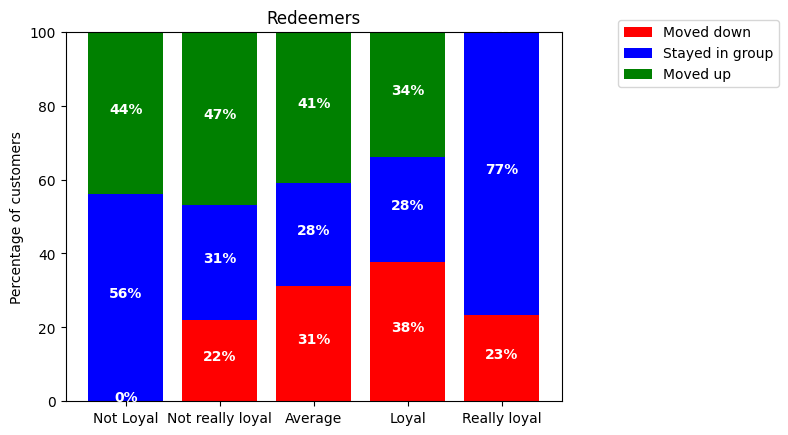

In [104]:
# Data
groups = ['Not Loyal', 'Not really loyal', 'Average', 'Loyal', 'Really loyal']
redeemed_values1 = [redeemed_moved_down_perc_group_1, redeemed_moved_down_perc_group_2, redeemed_moved_down_perc_group_3, redeemed_moved_down_perc_group_4, redeemed_moved_down_perc_group_5]
redeemed_values2 = [redeemed_stayed_perc_group_1, redeemed_stayed_perc_group_2, redeemed_stayed_perc_group_3, redeemed_stayed_perc_group_4, redeemed_stayed_perc_group_5]
redeemed_values3 = [redeemed_moved_up_perc_group_1, redeemed_moved_up_perc_group_2, redeemed_moved_up_perc_group_3, redeemed_moved_up_perc_group_4, redeemed_moved_up_perc_group_5]

fig, ax = plt.subplots()

# Stacked bar chart
ax.bar(groups, redeemed_values1, color='red', label='Moved down')
ax.bar(groups, redeemed_values2, bottom = redeemed_values1, color='blue', label='Stayed in group')
ax.bar(groups, redeemed_values3, bottom = np.add(redeemed_values1, redeemed_values2), color='green', label='Moved up')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('Percentage of customers')
ax.set_title('Redeemers')

for bar in ax.patches:
      ax.text(bar.get_x() + bar.get_width() / 2,
              bar.get_height() / 2 + bar.get_y(),
              str(round(bar.get_height())) + '%', ha = 'center',
              color = 'w', weight = 'bold', size = 10)

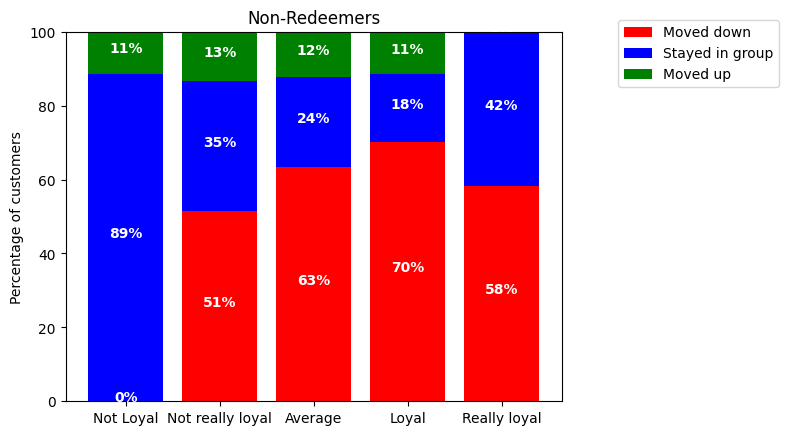

In [105]:
# Data
groups = ['Not Loyal', 'Not really loyal', 'Average', 'Loyal', 'Really loyal']
not_redeemed_values1 = [not_redeemed_moved_down_perc_group_1, not_redeemed_moved_down_perc_group_2, not_redeemed_moved_down_perc_group_3, not_redeemed_moved_down_perc_group_4, not_redeemed_moved_down_perc_group_5]
not_redeemed_values2 = [not_redeemed_stayed_perc_group_1, not_redeemed_stayed_perc_group_2, not_redeemed_stayed_perc_group_3, not_redeemed_stayed_perc_group_4, not_redeemed_stayed_perc_group_5]
not_redeemed_values3 = [not_redeemed_moved_up_perc_group_1, not_redeemed_moved_up_perc_group_2, not_redeemed_moved_up_perc_group_3, not_redeemed_moved_up_perc_group_4, not_redeemed_moved_up_perc_group_5]

fig, ax = plt.subplots()

# Stacked bar chart
ax.bar(groups, not_redeemed_values1, color='red', label='Moved down')
ax.bar(groups, not_redeemed_values2, bottom = not_redeemed_values1, color='blue', label='Stayed in group')
ax.bar(groups, not_redeemed_values3, bottom = np.add(not_redeemed_values1, not_redeemed_values2), color='green', label='Moved up')
ax.legend(bbox_to_anchor=(1.1, 1.05))
ax.set_ylabel('Percentage of customers')
ax.set_title('Non-Redeemers')

for bar in ax.patches:
      ax.text(bar.get_x() + bar.get_width() / 2,
              bar.get_height() / 2 + bar.get_y(),
              str(round(bar.get_height())) + '%', ha = 'center',
              color = 'w', weight = 'bold', size = 10)